In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from common import *

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Bidirectional, RepeatVector, TimeDistributed, Dropout, BatchNormalization

tf.keras.utils.set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-14 09:25:17.440615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 09:25:17.446206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 09:25:17.446369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [3]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Generate `Time`

In [4]:
data_with_time = generate_full_timestamp(data)

## 2) Imputing

In [5]:
data_imp = data_with_time.fillna(method='bfill')

## 3) Feature engineering

In [6]:
data_proc = preprocess(data_imp)

## 4) Feature selection

In [7]:
cols = ['Time', 'TurbID', 'RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'Wspd_cos', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
data_fin = data_proc[cols]

In [8]:
data_fin

,Time,TurbID,RPM,Bspd1,Bspd3,Bspd2,Wspd_cos,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv
0,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
1,2,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
2,3,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76
3,4,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53
4,5,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,28796,134,13.300998,13.300998,13.300998,13.300998,4.843796,4.86,113.646913,0.455178,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.13,308.65
3859196,28797,134,12.217265,12.217265,12.217265,12.217265,4.449136,4.46,88.069787,0.352134,0.01,0.01,0.01,2.745986,2.745986,2.745986,-93.64,221.60
3859197,28798,134,11.615510,11.615510,11.615510,11.615510,4.229996,4.23,75.686746,0.300476,0.01,0.01,0.01,2.745986,2.745986,2.745986,-111.20,220.60
3859198,28799,134,11.904266,11.904266,11.904266,11.904266,4.335151,4.36,81.472834,0.329171,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.04,222.15


## 4) Split dataset

In [9]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = False
TEST_SIZE   = 0.3
BATCH_SIZE  = 256

In [10]:
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_fin, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = generate_dataset(val_x, val_y, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x, batch_size=1)

100%|██████████| 134/134 [00:11<00:00, 12.17it/s]


Train data(X, y)     : (18358, 288, 16) (18358, 288, 16)
Validation data(X, y): (8040, 288, 16) (8040, 288, 16)
Test data(X)         : (134, 288, 16)


2022-07-14 09:25:43.119211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 09:25:43.119972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 09:25:43.120130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 09:25:43.120228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# 3. Modeling

In [11]:
model = Sequential([
    Input(shape=(train_x.shape[1],train_x.shape[2])),
    Bidirectional(GRU(units=256)),
    RepeatVector(train_y.shape[1]),
    Bidirectional(GRU(units=256, return_sequences=True)),
    TimeDistributed(Dense(units=train_x.shape[-1]))
])
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'], loss_weights=None)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 512)              420864    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 288, 512)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 288, 16)          8208      
 ibuted)                                                         
                                                                 
Total params: 1,611,792
Trainable params: 1,611,792
Non-

# 4. Training

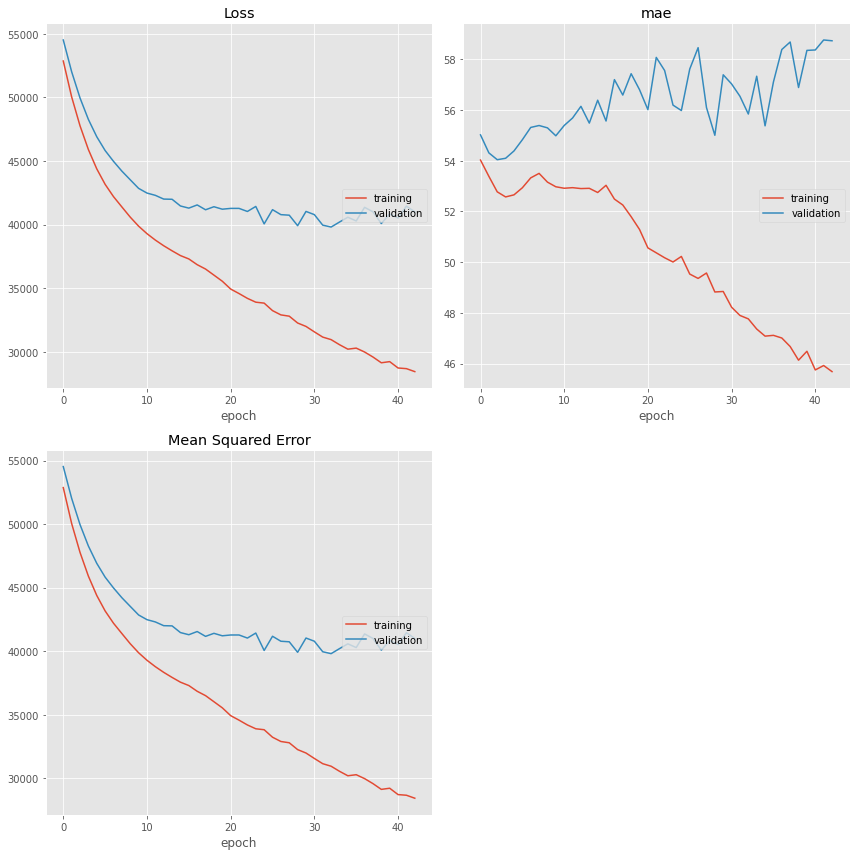

Loss
	training         	 (min: 28439.230, max: 52870.305, cur: 28439.230)
	validation       	 (min: 39810.328, max: 54523.941, cur: 41003.250)
mae
	training         	 (min:   45.680, max:   54.025, cur:   45.680)
	validation       	 (min:   54.040, max:   58.762, cur:   58.731)
Mean Squared Error
	training         	 (min: 28439.227, max: 52870.297, cur: 28439.227)
	validation       	 (min: 39810.320, max: 54523.934, cur: 41003.254)
72/72 [==============================] - 7s 95ms/step - loss: 28439.2305 - mse: 28439.2266 - mae: 45.6802 - val_loss: 41003.2500 - val_mse: 41003.2539 - val_mae: 58.7314 - lr: 5.3144e-04


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

model.fit(train_ds, validation_data=val_ds, epochs=1000,
          callbacks=[
              PlotLossesKeras(),
              EarlyStopping(patience=10, restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
          ]);

# 5. Check results

## 1) Training set

574/574 [==============================] - 16s 28ms/step


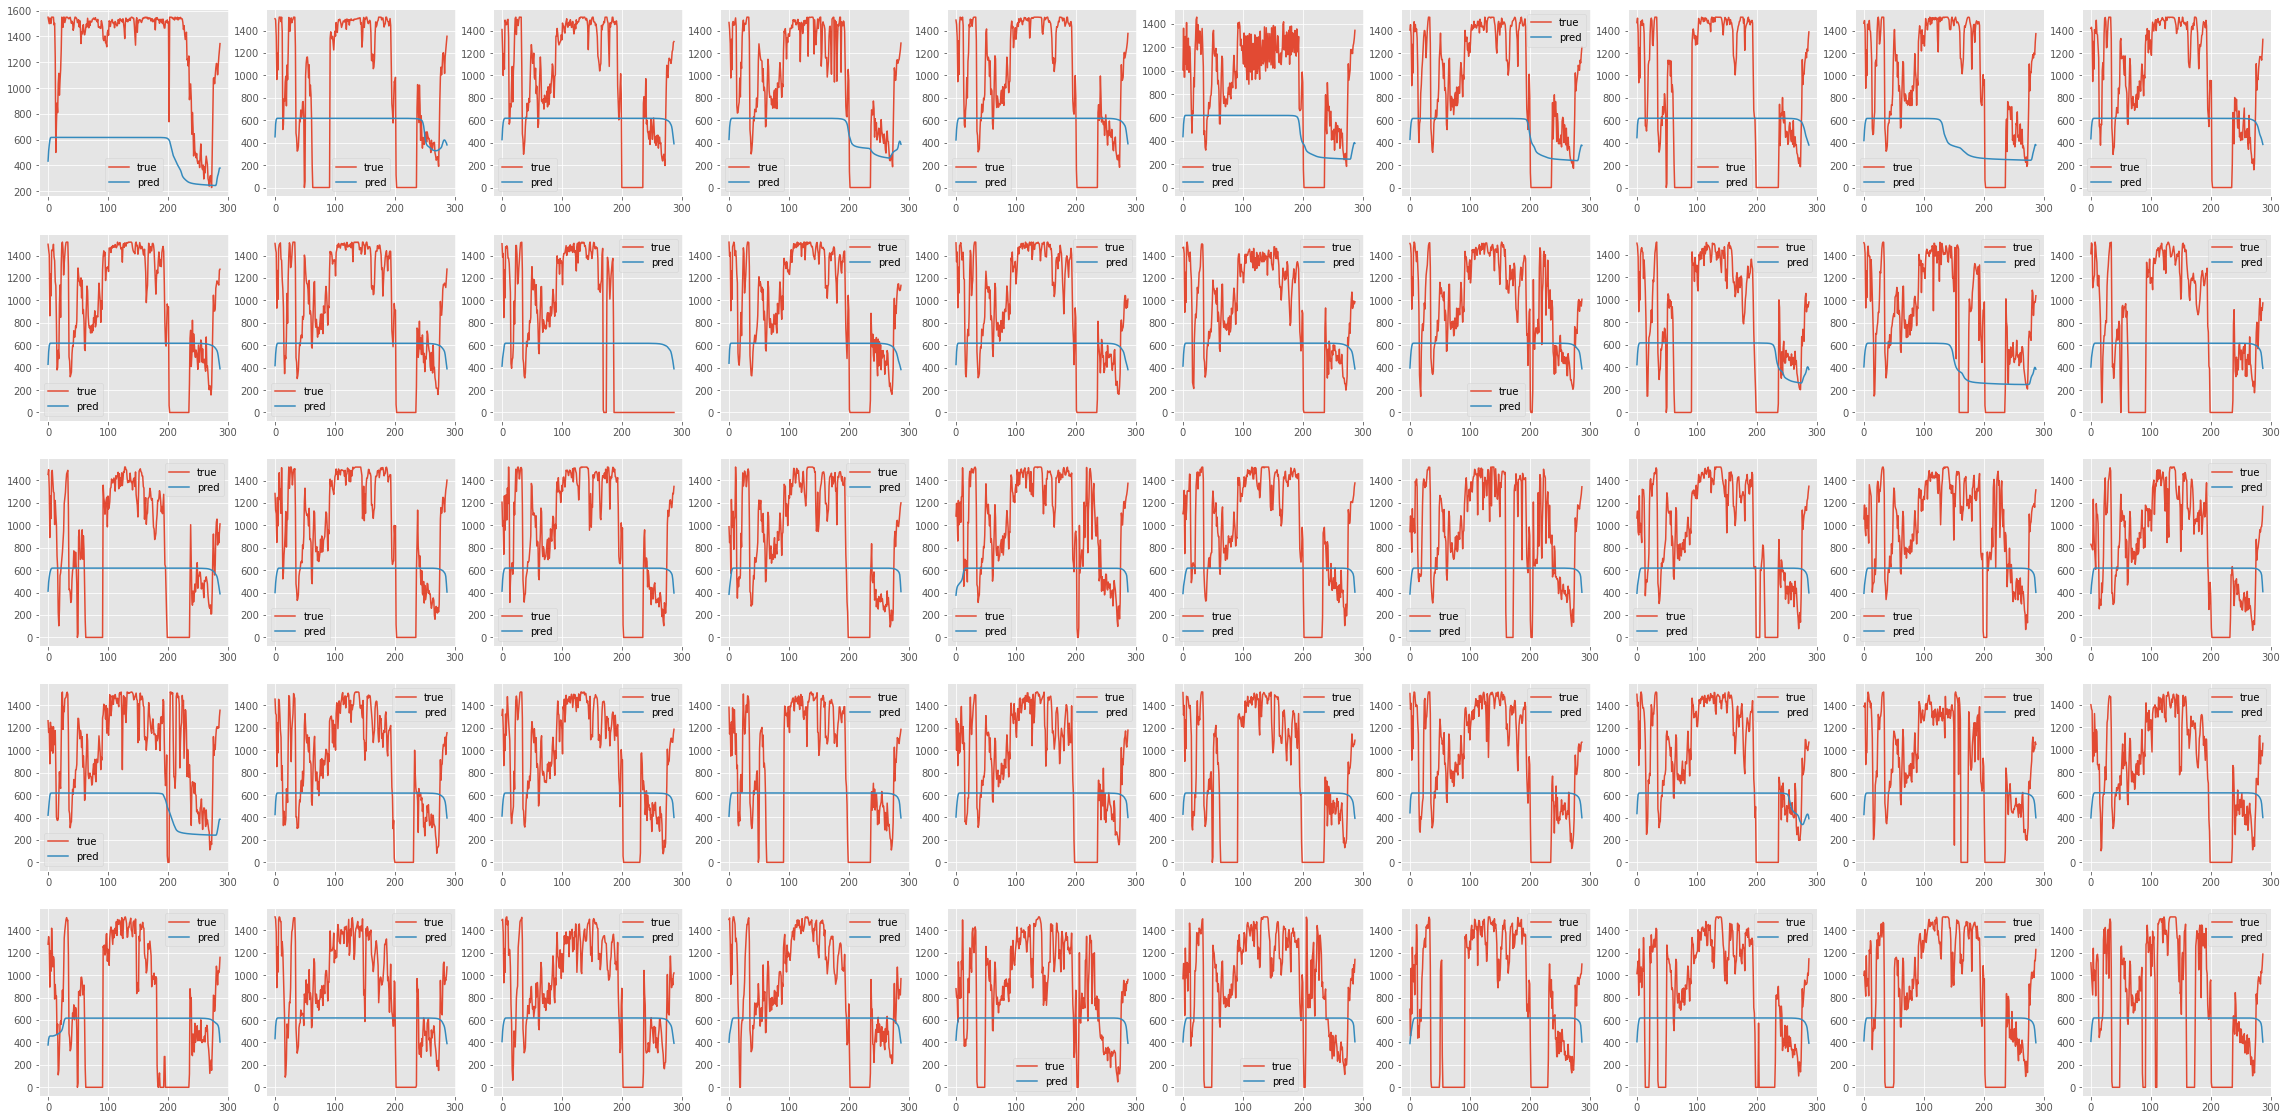

In [16]:
y_true = train_y[:, :, -1]
y_pred = model.predict(train_x)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

## 2) Validation set

252/252 [==============================] - 7s 28ms/step


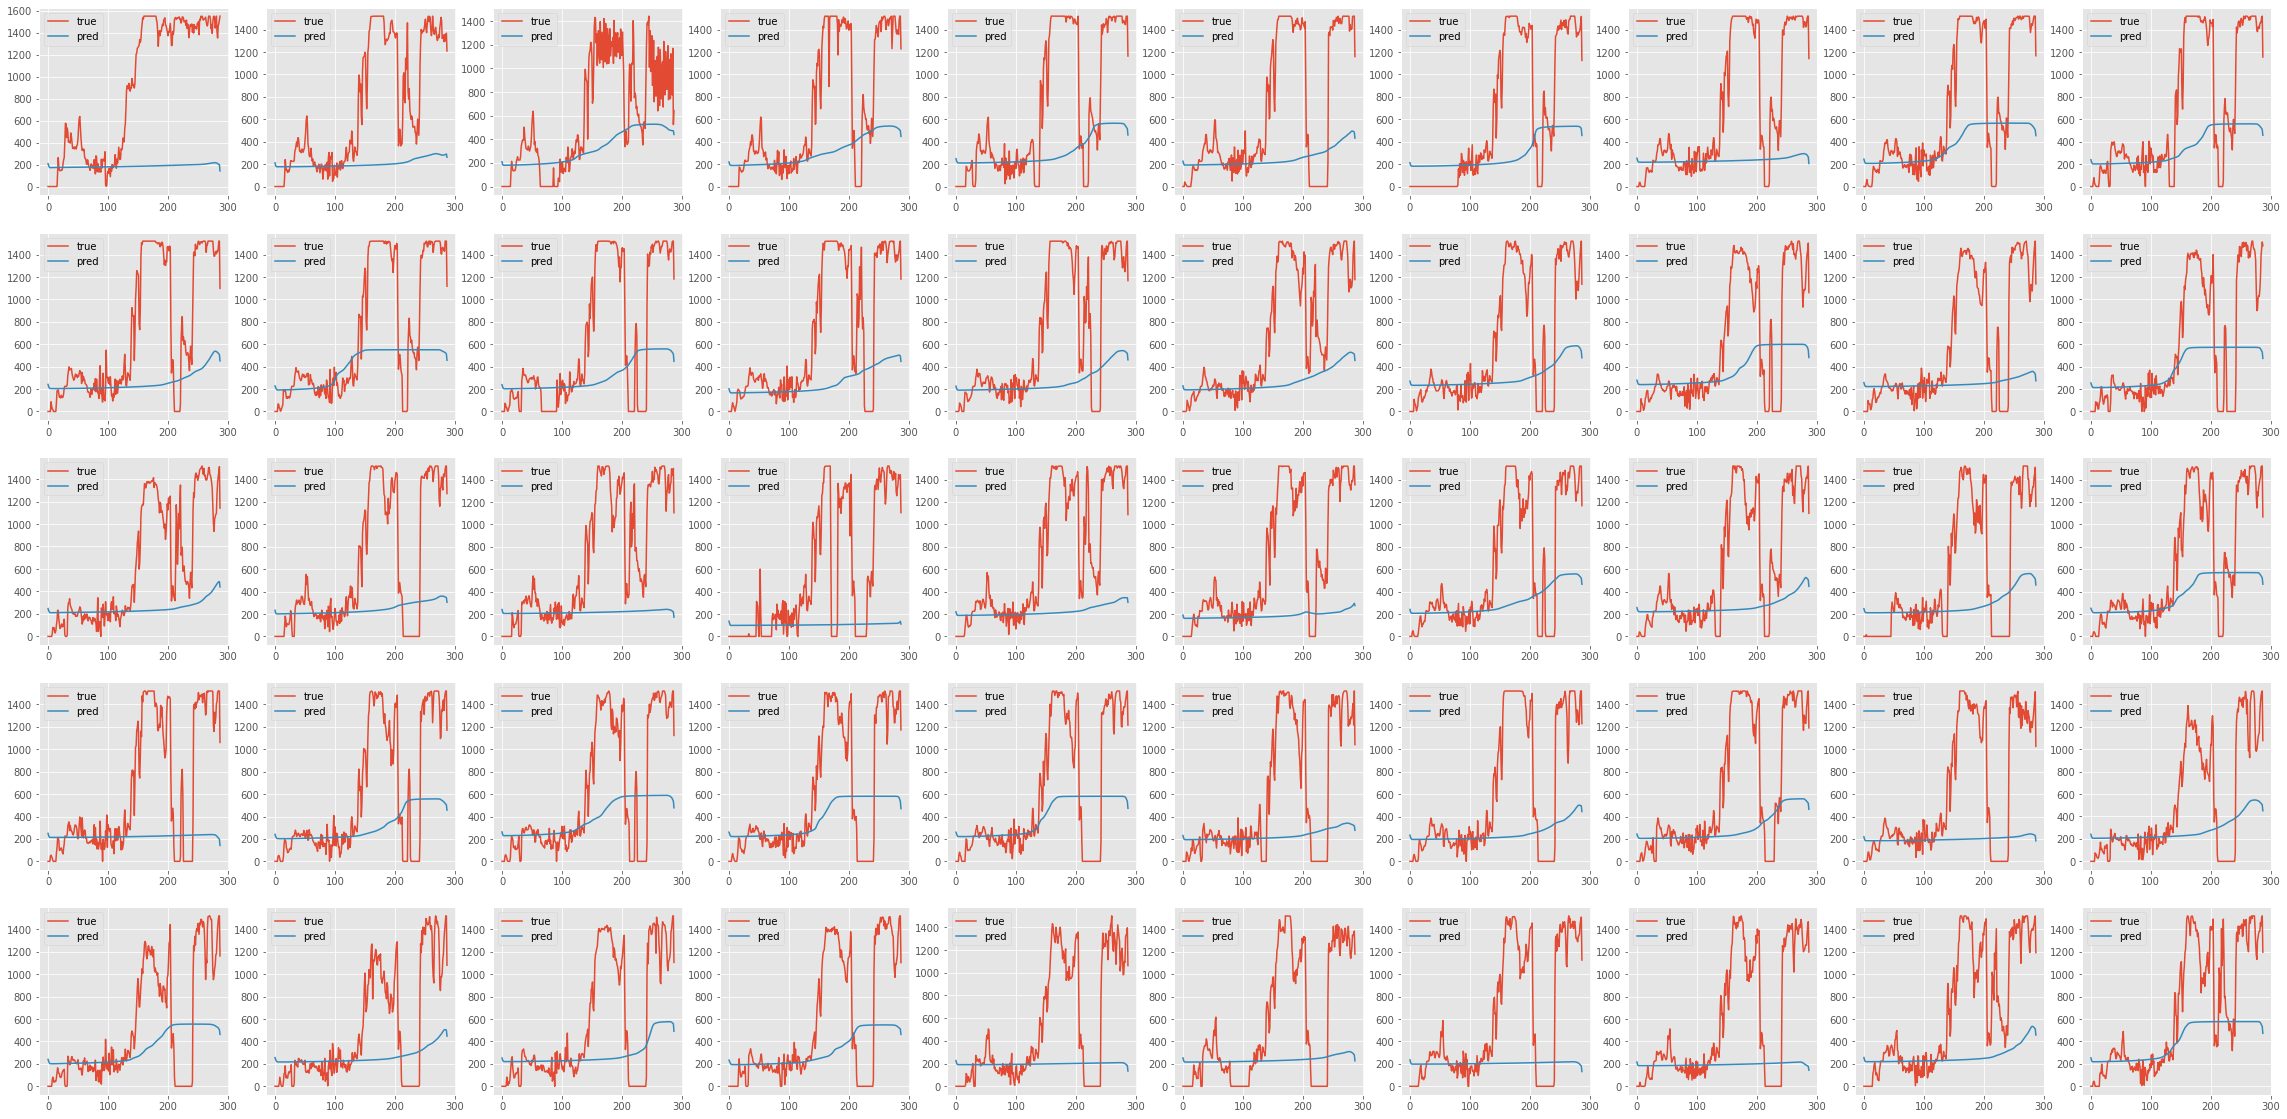

In [17]:
y_true = val_y[:, :, -1]
y_pred = model.predict(val_x)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# 6. Generate submission

In [18]:
sample_submission['Patv'] = model.predict(test_x)[:, :, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed11-Remake-full.csv"), index=False)

5/5 [==============================] - 0s 24ms/step
